# Read the dataset file “labels.csv”
visualizing the data

In [1]:
%matplotlib inline
from os.path import join
import pandas as pd

# relative path
DATA_FILES_PATH = '../Dog-Breed-Classifier/testData/'

# loading labels.csv
INTRO_DF = pd.read_csv(join(DATA_FILES_PATH, 'labels.csv'))

# describe the dataset
INTRO_DF.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


# Breed image distribution

In [2]:
INTRO_DF.pivot_table(index='breed',aggfunc=len).sort_values('id',ascending=True).describe()

,id
count,120.000000
mean,85.183333
std,13.298122
min,66.000000
25%,75.000000
50%,82.000000
75%,91.250000
max,126.000000


#### Scottish_deerhound being the largest
#### Briard being the smallest

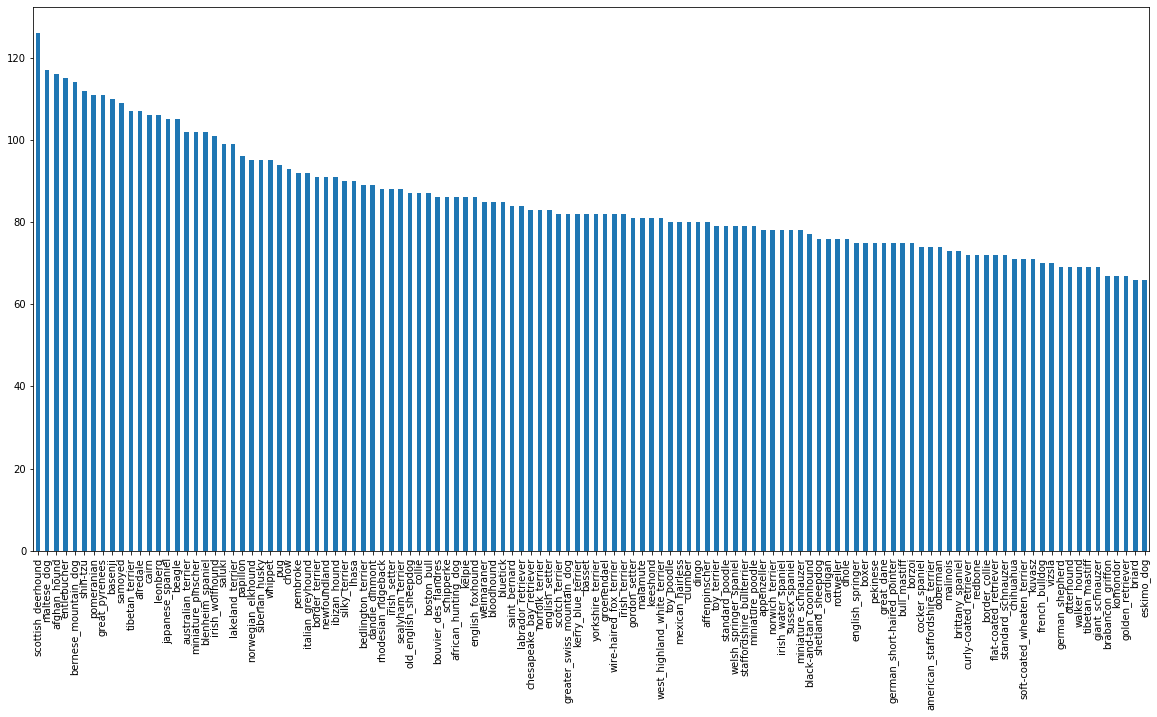

In [3]:
# we can choose from 2 option views

# opition 1
# ax=pd.value_counts(INTRO_DF['breed'],ascending=True).plot(kind='barh',
#                                                        fontsize="40",
#                                                        title=" Dog Distribution",
#                                                        figsize=(50,100))
# ax.set(xlabel="Images per class", ylabel="Classes")
# ax.xaxis.label.set_size(40)
# ax.yaxis.label.set_size(40)
# ax.title.set_size(60)

# opition 2
INTRO_DF["breed"].value_counts().plot.bar(figsize=(20, 10))


In [4]:
uniqueBreeds = INTRO_DF.breed.unique()
# print(uniqueBreeds)
dictBreed = dict(zip(uniqueBreeds,range(len(uniqueBreeds))))
# print(dictBreed)
INTRO_DF['breedNum'] = INTRO_DF['breed'].map(dictBreed)
INTRO_DF[:10]

,id,breed,breedNum
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,0
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,1
2,001cdf01b096e06d78e9e5112d419397,pekinese,2
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,3
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,4
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier,5
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier,5
7,002a283a315af96eaea0e28e7163b21b,borzoi,6
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,7
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,8


### training 

In [5]:

from glob import glob
import re

TRAIN_PATH = (join(DATA_FILES_PATH, 'train/*'))

arr_paths = glob(TRAIN_PATH)
labels = []
for ids in arr_paths:
    ids = re.split(r'(\\|/)',ids)[-1].split(".")[0]
    breed_name = list(INTRO_DF[INTRO_DF.id == ids]["breed"])[0]
    breed_ids = dictBreed[breed_name]
    labels.append(breed_ids)

# ids = ids[:1000]
# labels = labels[:1000]
print(labels[:10])



[38, 116, 45, 4, 69, 35, 104, 77, 113, 46]


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(arr_paths, labels, test_size=0.2, random_state=42 )

## Resizing image  

In [7]:

import numpy as np
import PIL.Image

image_resize = 60
nwidth = image_resize
nheight = image_resize

# nwidth x nheight = number of features because images are nwidth x nheight pixels
s = (len(INTRO_DF['breed']), nwidth, nheight,3) 
allImage = np.zeros(s)

i = 0
for fileName, breed,num in INTRO_DF.values:
    image = PIL.Image.open(f'../Dog-Breed-Classifier/testData/train/{fileName}.jpg')
    image = image.resize((nwidth, nheight))
    image = np.array(image)
    image = np.clip(image/255.0, 0.0, 1.0) # 255 = max of the value of a pixel
    i += 1
    allImage[i-1]=image

    train = allImage

testing

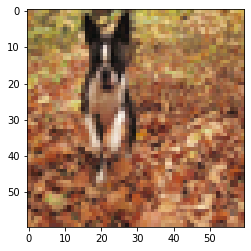

In [8]:
import matplotlib.pyplot as plt

lum_img = train[0,:,:,:]
plt.imshow(lum_img)
plt.show()